In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import multivariate_normal

# import fitter
from HMC import HMC
from logMultiGaussianLikeli import log_Likelihood_MultidimensionalGaussian
import sys
sys.path.append("..")
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.MultiGaussianLikeli import Likelihood_MultidimensionalGaussian

### Data and visualization
With extension to `MCMC_DianZhang/test.ipynb`.

Visualise the distribution $N(\left( \begin{array}{c} 0 \\ 0 \end{array}\right),\left( \begin{array}{cc} 2.5 & 0.5 \\ 0.5 & 2 \end{array}\right))$.  

In [8]:
mean = [0, 0]
cov = [[2.5, 0.5], [0.5, 2]]
rv = multivariate_normal(mean=mean, cov=cov)
dataset = np.random.multivariate_normal(mean,cov,100)

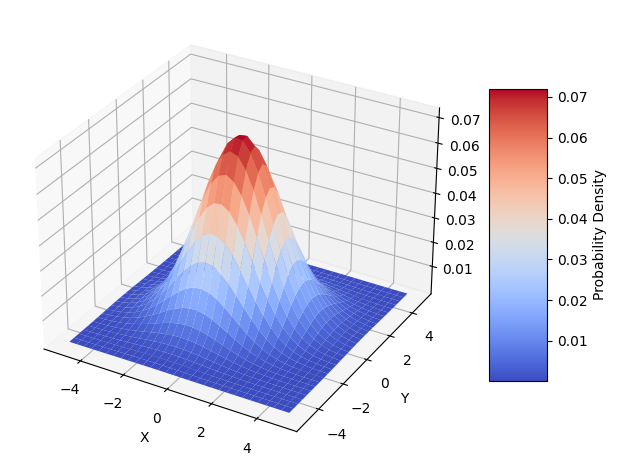

In [9]:
# number of points (30, 30)
X, Y = np.mgrid[-5.:5.:30j, -5.:5.:30j]

# Need an (N, 2) array of (x, y) pairs
DATA = np.dstack((X.flat, Y.flat))
Z = rv.pdf(DATA)
# reshape back to a (30, 30) grid
Z = Z.reshape(X.shape)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Probability Density')
surf = ax.plot_surface(X,Y,Z,cmap='coolwarm')
#wire = ax.plot_wireframe(X,Y,Z,cmap='coolwarm')

fig.colorbar(surf, shrink=0.65,aspect=5,label='Probability Density')
plt.tight_layout()
plt.show()

C:\Users\jq822\AppData\Local\Temp\ipykernel_7944\1480310642.py:5: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, Z, level=15, cmap='Blues')


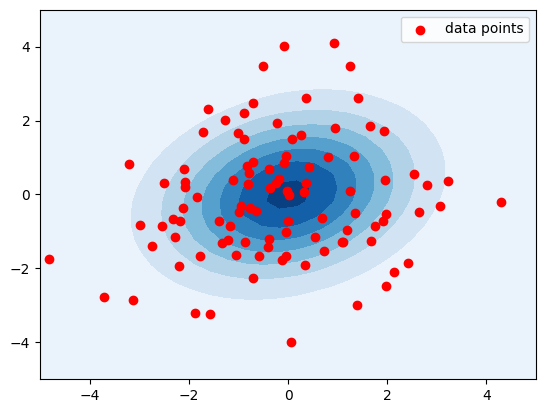

In [10]:
X, Y = np.mgrid[-5.:5.:30j, -5.:5.:30j]
DATA = np.dstack((X, Y))
Z = rv.pdf(DATA)

plt.contourf(X, Y, Z, level=15, cmap='Blues')
plt.scatter(dataset[:,0],dataset[:,1],label='data points',color='red')
plt.legend()
plt.show()

### Likelihood for a 2D Gaus

In [11]:
Likeli = Likelihood_MultidimensionalGaussian(Dim=2, Sigma=cov, Dataset=dataset)

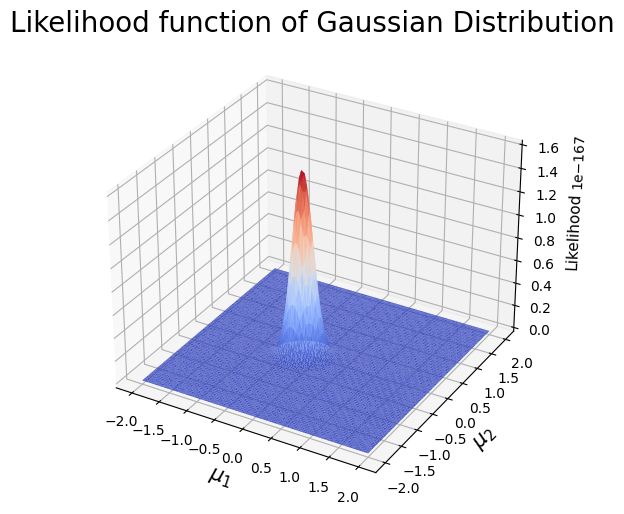

In [12]:
Grid = np.linspace(-2, 2, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid+mean[1])
    x += [g+mean[0]]*r
    z += [Likeli.L([g+mean[0], k+mean[1]]) for k in Grid]
# x, y, z = np.array(x), np.array(y), np.array(z)
# z = z.reshape((100,100))

fig = plt.figure(figsize=(10,6),facecolor="white")

Gau = fig.add_subplot(projection="3d")
Gau.plot_trisurf(x, y, z, cmap='coolwarm')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("Likelihood", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution", fontsize=20)

plt.show()

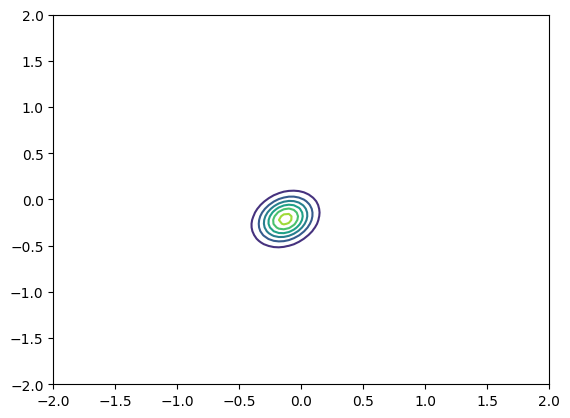

In [13]:
x_, y_ = list(Grid+mean[0]), list(Grid+mean[1])
z_ = np.array(z)
z_ = z_.reshape((len(x_),len(y_)))
plt.contour(x_,y_,z_)

In [14]:
def U(theta: List[float]) -> float: # the potential energy function: U(theta) = -log(probability distribution of theta)
    return (- np.log(Likeli.L(theta)))

def grad_U(theta: List[float]) -> float:
    DRho = Likeli.dLdmu(theta)
    Rho = Likeli.L(theta)*(-1)
    return np.array([DRho/Rho for DRho in DRho])

In [15]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.001, U=U, grad_U=grad_U, current_theta=[1, 1])

In [17]:
print('The accpetance rate =', len(theta_accept)/(len(theta_reject)+len(theta_accept)))

The accpetance rate = 0.9135


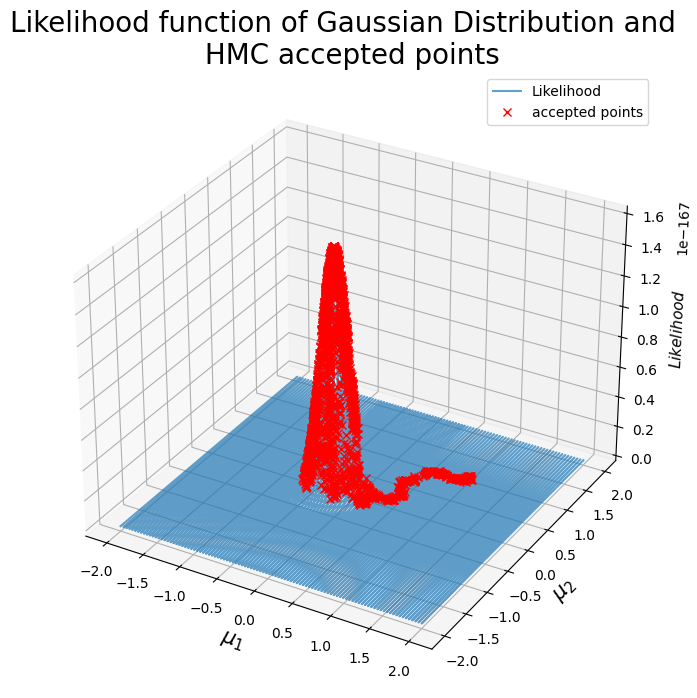

In [29]:
_x = []
_y = []
_z = []
for i in theta_accept:
    _x.append(i[0])
    _y.append(i[1])
    _z.append(Likeli.L([i[0], i[1]]))

Grid = np.linspace(-2, 2, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [Likeli.L([g, k]) for k in Grid]

fig = plt.figure(figsize=(8, 8), facecolor="white")

Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7, label='Likelihood')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$Likelihood$", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution and \n HMC accepted points", fontsize=20)

Gau.plot(_x,_y, _z, 'x', color='red', label='accepted points')

plt.legend()
plt.show()

#### using `numpyro`

In [9]:
from numpyro import distributions

target_dist = distributions.MultivariateNormal(
    np.array([0, 0]), np.array([[2.5, 0.5], 
                           [0.5, 2]]))

def target_log_prob_fn(state):
    return target_dist.log_prob(state)

ModuleNotFoundError: No module named 'numpyro'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


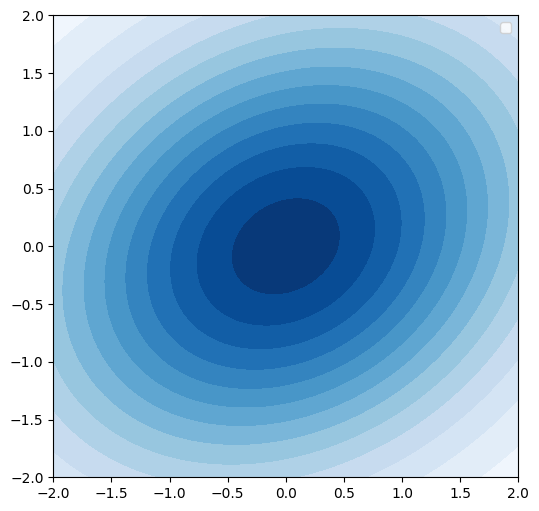

In [ ]:
X, Y = np.meshgrid(np.linspace(-2, 2, 100), 
                   np.linspace(-2, 2, 100), 
                  )

_X = np.stack([X, Y]).reshape(2, -1)
probs = np.exp(target_log_prob_fn(_X.T).reshape((100, 100)))

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(
    X, Y,
    probs, 
    levels=15,
    cmap='Blues'
)

ax.legend()

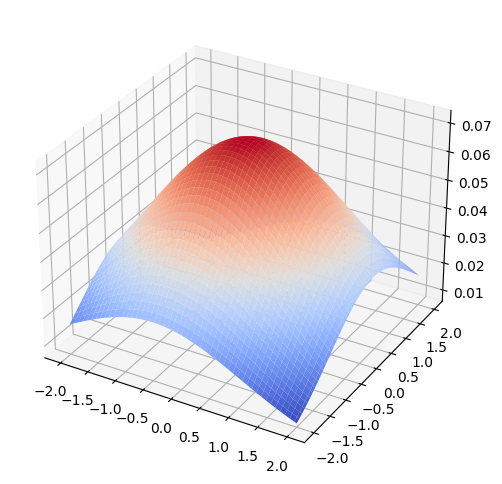

In [ ]:
fig = plt.figure(figsize=(10,6),facecolor="white")

ax = fig.add_subplot(projection="3d")
ax.plot_surface(X,Y,probs,cmap='coolwarm')

### Likelihood for Multi-dimensional Gaus

**Info in the link [How to evaluate the multivariate normal log likelihood](https://blogs.sas.com/content/iml/2020/07/15/multivariate-normal-log-likelihood.html#:~:text=The%20log%2Dlikelihood%20for%20a,also%20called%20a%20log%2DPDF.)**

The log-likelihood for a vector $\mathbf{x}$ is the natural logarithm of the **multivariate normal (MVN)** density function evaluated at $\mathbf{x}$. A probability density function is usually abbreviated as PDF, so the log-density function is also called a log-PDF.

**The multivariate normal PDF**

The multivariate normal distribution in dimension $d$ has two parameters: A d-dimensional mean vector $\mathbf{\mu}$ and a $d \times d$ covariance matrix $\mathbf{\Sigma}$. The MVN PDF evaluated at a d-dimensional vector $\mathbf{x}$ is

$f(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^{d}|\mathbf{\Sigma}|}} exp(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^{T} \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu}))$

where $\mathbf{\Sigma}$ is the determinant of $\mathbf{\Sigma}$.

**Evaluate the MVN log-likelihood function**

$\log (f(\mathbf{x})) = -\frac{1}{2}[d \log (2 \pi) + log (|\mathbf{\Sigma}|) + MD(\mathbf{x}; \mathbf{\mu}, \mathbf{\Sigma})^{2}]$

where $MD$ is the Mahalanobis distance between the point $\mathbf{x}$ and the mean vector $\mathbf{\mu}$.

$N(\left( \begin{array}{c} 0 \\ 0 \\ 2 \\ 2 \end{array}\right),\left( \begin{array}{cc} 1 & -1 & 2 & 0 \\ -1 & 4 & -1 & 1 \\ 2 & -1 & 6 & -2 \\ 0 & 1 & -2 & 4 \end{array}\right))$

In [2]:
mean = [0, 0, 2, 2]
cov = [[1., -1., 2., 0.], 
        [-1., 4., -1., 1.], 
        [2., -1., 6., -2.], 
        [0., 1., -2., 4.]]
rv = multivariate_normal(mean=mean, cov=cov)
dataset = np.random.multivariate_normal(mean,cov,100)

In [3]:
Likeli = Likelihood_MultidimensionalGaussian(Dim=4, Sigma=cov, Dataset=dataset)
logLikeli = log_Likelihood_MultidimensionalGaussian(Dim=4, Sigma=cov, Dataset=dataset)

#### With HMC

from [log likelihood](https://stats.stackexchange.com/questions/27436/how-to-take-derivative-of-multivariate-normal-density)

In [4]:
def U(theta: List[float]) -> float:
    '''
    the potential energy function: 
    U(theta) = -log(probability distribution of theta)
    '''
    return - logLikeli.logL(theta)

def grad_U(theta: List[float]) -> float:
    '''
    the derivative of the potential energy function
    dU/dmu
    '''
    DRho = logLikeli.dlogLdmu(theta)
    Rho = logLikeli.logL(theta)*(-1)
    return np.array([DRho/Rho for DRho in DRho])

In [5]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.001, U=U, grad_U=grad_U, current_theta=np.array([0,0,0,0]))

In [6]:
print('The accpetance rate =', len(theta_accept)/(len(theta_reject)+len(theta_accept)))

The accpetance rate = 0.6145


### Gaussian Mixture
